# Energy Economics Seminar - Optimal Energy Storage 

This notebook contains the code to simulate the models used in the "Optimal Energy Storage" seminar paper.

In [1]:
# Load packages used in the project
using IJulia, Revise        # QoL packages
using JuMP, HiGHS           # Modelling packages
using Plots, StatsPlots     # Plotting packages
using DataFrames, CSV, XLSX # Data wrangling packages

# Load custom helper module
includet("modelsetup.jl")
includet("dataloading.jl")
using .ModelSetup, .DataLoading  

## Loading and organising data

In [2]:
# Load hourly generation data from the OPS Platform
input_data = CSV.read("..\\input\\time_series_60min_singleindex.csv", DataFrame)
df_hourly = select(input_data, 2, r"DK")[:,1:11]
# Create a mask to select 2018 data
mask = Vector{Bool}()
for row in df_hourly[:,1]
    if occursin("2018", row)
        push!(mask, true)
    else
        push!(mask, false)
    end
end
df_hourly = df_hourly[mask,:]    # Select only 2018 data

# Load aggregated capacity data for conventional plants from the OPS Platform
input_data = CSV.read("..\\input\\national_generation_capacity_stacked_filtered.csv", DataFrame)
df_cap = input_data[input_data[:,:year] .== 2018,:] # Select only data from 2018
df_cap = df_cap[df_cap[:,:source] .== "ENTSO-E Power Statistics",:] # Select only data from ENTSO-E
df_cap_tot = df_cap[df_cap[:,:energy_source_level_1] .== 1 , [:technology, :capacity]]  # Create subset of aggregate capacities
append!(df_cap_tot, df_cap[df_cap[:,:energy_source_level_0] .== 1, [:technology, :capacity]])   # Add total capacity to subset of aggregates
df_cap_higher = df_cap[df_cap[:,:energy_source_level_2] .== 1, [:technology, :capacity]]
df_cap_lower = df_cap[df_cap[:,:energy_source_level_3] .== 1, [:technology, :capacity]]
df_cap_wind = append!(df_cap[df_cap[:,:technology] .== "Onshore", [:technology, :capacity]], df_cap[df_cap[:,:technology] .== "Offshore", [:technology, :capacity]])

Row,technology,capacity
,String,Float64?
1,Onshore,4422.6
2,Offshore,1700.8


In [42]:
df_cap_tot[5,2]

14518.865

In [39]:
sum(df_cap_higher[Not(14),2])

14518.865000000002

In [68]:
append!(df_cap_lower[[1, 5, 10, 14, 17], :], df_cap_wind)

Row,technology,capacity
,String,Float64?
1,Biomass and biogas,1033.02
2,Hard coal,3656.4
3,Natural gas,1829.0
4,Other bioenergy and renewable waste,322.9
5,Solar,1000.1
6,Onshore,4422.6
7,Offshore,1700.8


In [71]:
append!(df_cap_lower[[1, 5, 10, 14, 17], :], df_cap_wind)

Row,technology,capacity
,String,Float64?
1,Biomass and biogas,1033.02
2,Hard coal,3656.4
3,Natural gas,1829.0
4,Other bioenergy and renewable waste,322.9
5,Solar,1000.1
6,Onshore,4422.6
7,Offshore,1700.8


In [76]:
input_capfac = CSV.read("../input/ninja_pv_wind_profiles_singleindex_filtered.csv", DataFrame)
mask = Vector{Bool}()
    for row in input_capfac[:,1]
        if occursin("2018", row)
            push!(mask, true)
        else
            push!(mask, false)
        end
    end
df_capfac = input_capfac[mask, [1,2,4,5]]
reshape(df_capfac[:,4], (1,:))

1×8760 Matrix{Float64}:
 0.2624  0.2617  0.2596  0.2604  0.3198  …  0.6798  0.7107  0.7359  0.7717

In [44]:
sum(df_cap_lower[Not(16),2])

14518.865

In [3]:
sum(df_cap_higher[[4, 9, 15, 16, 17], 2])/df_cap_tot[5,2]

0.9618393035543755

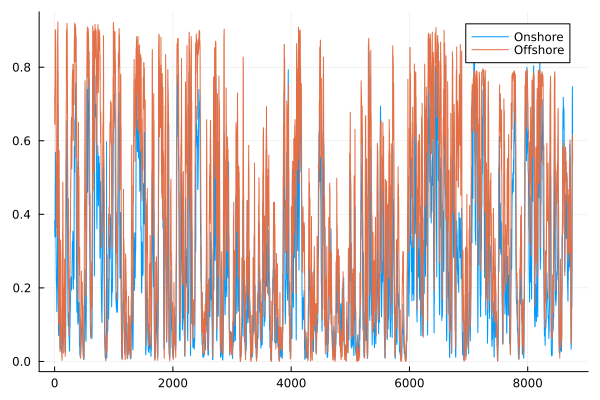

In [3]:
# Plot capacity factors for wind 
plot(1:8760, [df_hourly[:,11]./df_hourly[:,10] df_hourly[:,9]./df_hourly[:,8]], label=["Onshore" "Offshore"])

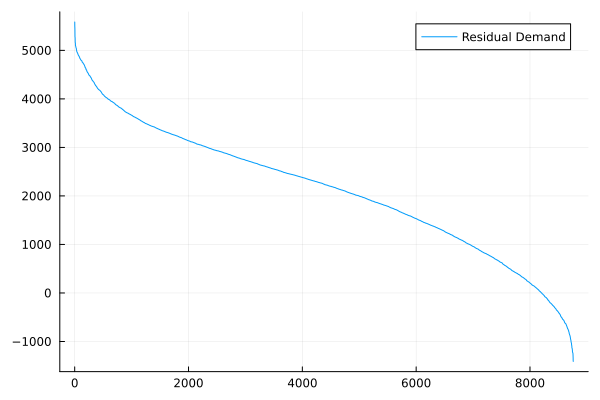

In [13]:
# Plot initial residual demand in 2018
plot(1:8760, sort(df_hourly[:,2] .- df_hourly[:,5] .- df_hourly[:,7], rev=true), label="Residual Demand")

In [4]:
# Load cost structure data from the Danish Energy Agency
input_sheet = XLSX.readdata("../input/Data collection.xlsx", "Data til simulering v2", "A2:M9")
input_sheet[1, :]

13-element Vector{Any}:
 "Electricity plants"
 "Investment cost"
 "FOM"
 "Variable OEM "
 "Fuel efficiency"
 "Fuel intensity"
 "Fuel price"
 "Fuel cost"
 "Total variable cost"
 "Technical lifetime"
 "Depreciation (no discounting)"
 "Emission intensity"
 "Emission intensity Electric"

In [36]:
[df_cap_wind[1,1], df_cap_wind[2,1], df_cap_higher[15,1], df_cap_higher[4,1], df_cap_higher[9,1], df_cap_higher[17,1]]

6-element Vector{String}:
 "Onshore"
 "Offshore"
 "Solar"
 "Hard coal"
 "Natural gas"
 "Bioenergy and renewable waste"

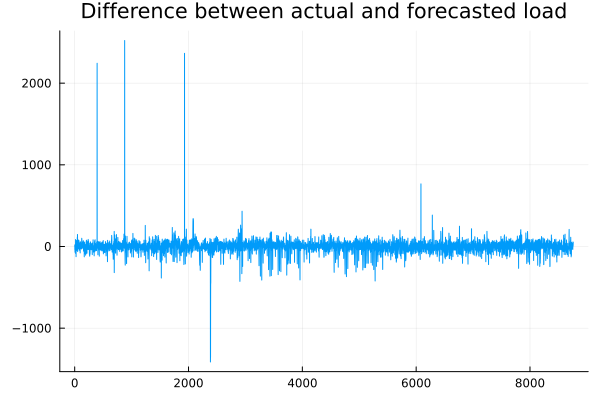

In [28]:
plot(1:8760, df_hourly[:,2] .- df_hourly[:,3], label=nothing, title="Difference between actual and forecasted load")

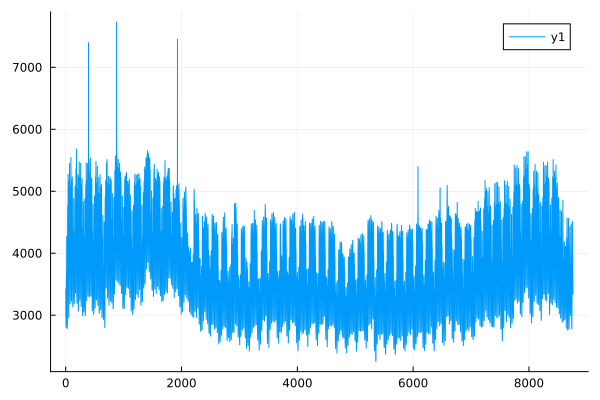

In [9]:
plot(1:8760, df_hourly[:,2])

## Model simulations

In [5]:
# Testing out the basic intermittent energy system model with real data
# Initialise vectors with capacity constraints and marginal costs
q_vec   = [df_cap_wind[1,2], df_cap_wind[2,2], df_cap_higher[15,2], df_cap_higher[4,2], df_cap_higher[9,2], df_cap_higher[17,2]]    # Vector of generation capacities
c_vec   = Vector{Float64}(input_sheet[3:end, 9])  # Vector of marginal costs
fom_vec = Vector{Float64}(input_sheet[3:end, 3])  # Vector of fixed operating and maintenance costs
L_vec   = Vector{Float64}(df_hourly[:,2])         # Vector of load at different hours
u = maximum(c_vec) + 10  # Marginal WTP to avoid load-shedding

# Initialise matrices with hourly capacity constraints
gamma_mat = (df_hourly[:,11]./df_hourly[:,10])' # Initialise matrix of gamma values with intermittent generator values
gamma_mat = [gamma_mat; (df_hourly[:,9]./df_hourly[:,8])']   
gamma_mat = [gamma_mat; (df_hourly[:,5]./df_hourly[:,4])']
while size(gamma_mat, 1) < length(q_vec)    # Update gamma matrix until all generators have gamma values
    gamma_mat = [gamma_mat; [1 for i in 1:length(L_vec)]']  # Update gamma matrix with 1's for dispatchable generators
end
qh_mat = Array{Float64}(undef, length(q_vec), length(L_vec))            # Initialise matrix of hourly generation capacities
for i in 1:size(qh_mat,1)
    qh_mat[i,:] = q_vec[i] * gamma_mat[i,:]     # Update matrix by multiplying capacity with gamma value in each hour
end

# Create a SystemData object with the previously defined data
init_data = SystemData([:WindOffshore, :WindOnshore, :Solar, :Coal, :NaturalGas, :Bio],
                    q_vec, qh_mat, c_vec, fom_vec, L_vec, u)

Electricity system data for 6 plants and 8760 hours registered:
WindOffshore: Capacity = 4423, Marginal Cost = 5.0,   Fixed operating and maintenance costs = 50000
WindOnshore : Capacity = 1701, Marginal Cost = 1.5,   Fixed operating and maintenance costs = 14000
Solar       : Capacity = 1000, Marginal Cost = 0.0,   Fixed operating and maintenance costs = 11300
Coal        : Capacity = 3656, Marginal Cost = 21.4,  Fixed operating and maintenance costs = 31500
NaturalGas  : Capacity = 1829, Marginal Cost = 40.0,  Fixed operating and maintenance costs = 29300
Bio         : Capacity = 1356, Marginal Cost = 115.0, Fixed operating and maintenance costs = 66000


In [6]:
test_out = solve_system_model(init_data)

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
8760 rows, 47100 cols, 47100 nonzeros
5382 rows, 35339 cols, 35339 nonzeros
Presolve : Reductions: rows 5382(-3378); columns 35339(-25981); elements 35339(-25981)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -3.5394395728e+09 Pr: 5382(2.3005e+07) 0s
       5382    -3.2585034964e+09 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 5382
Objective value     :  3.2585034964e+09
HiGHS run time      :          0.10


Model solved without load shedding


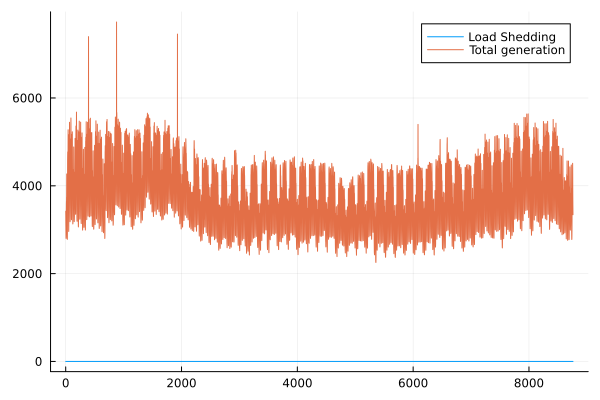

In [7]:
# Plot model solution for load shedding and total generation in each hour
plot(1:8760, [test_out.shedding sum(test_out.generation.data, dims=1)[:]], label=["Load Shedding" "Total generation"])

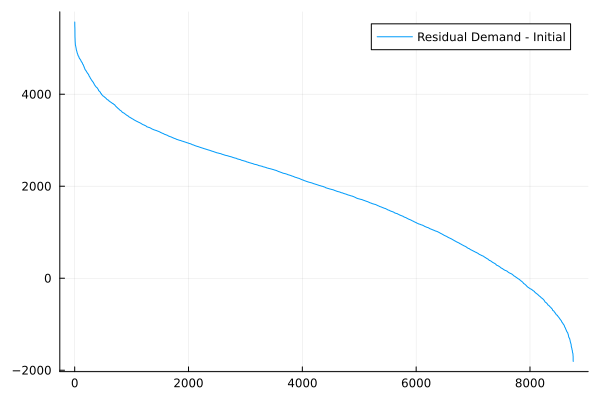

In [146]:
# Plot initial model residual demand in 2018
model_plot = plot(1:8760, [sort(L_vec - sum(qh_mat[1:3, :], dims=1)[:], rev=true)], label="Residual Demand - Initial")

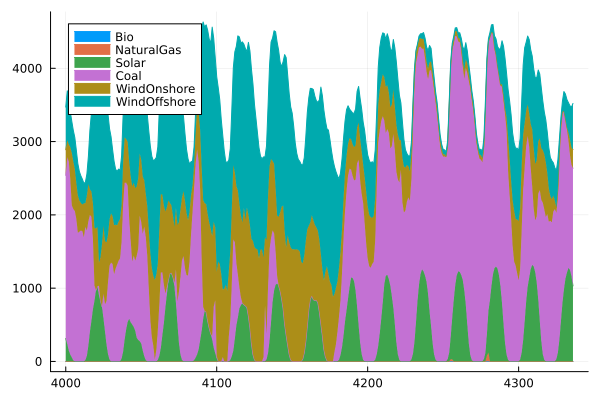

In [8]:
global genout, genlabels
for (i, sym) in enumerate(test_out.generation.axes[1])
    if i == 1
        genout = test_out.generation[sym, :].data
        genlabels = [string(sym)]
    else
        genout = [genout test_out.generation[sym, :].data]
        genlabels = [genlabels string(sym)]
    end
end
genout = sortslices(genout, dims=2)
for i in 1:size(genout, 2)
    for sym in test_out.generation.axes[1]
        if genout[:,i] == test_out.generation[sym,:]
            genlabels[i] = string(sym)
        end
    end
end
areaplot(4000:4336, genout[4000:4336, :], labels=genlabels)

In [32]:
test_out.generation[:Coal,:]

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, Base.OneTo(8760)
And data, a 8760-element Vector{Float64}:
 531.5753643689595
 425.0596292791106
 464.11431803455207
 280.06213182079546
 161.29108271198174
  55.56913669425876
   0.0
  87.59348083013128
   2.977425469811351
  14.760480459873179
   ⋮
 629.5745840248101
 548.6385301526948
 549.2667550037545
 218.42733292642606
   0.0
   0.0
   0.0
   0.0
   0.0

In [20]:
(sum(test_out.generation.data, dims=2))./sum(test_out.generation.data)

6×1 Matrix{Float64}:
 0.2711337068827095
 0.17295638278439057
 0.05247914384797394
 0.49039842612493634
 0.013029824036288593
 2.5163237046750526e-6